# Demographics of participants

### Data to report outliers and overall dropout rate are PARTICIPANTS
### Data for the detailed analysis are VALID_PARTICIPANTS
##### (see cleaning_sampling.ipynb for details)

In [29]:
from configparser import ConfigParser
from sqlalchemy import create_engine
import pandas as pd
from ua_parser import user_agent_parser
from geolite2 import geolite2
import geopandas as gpd
import pycountry
import re
import statsmodels.api as sm
from statsmodels.formula.api import ols
import seaborn as sns
print(sns.__version__)
import matplotlib.pyplot as plt
%matplotlib inline
sns.set(color_codes=True)
sns.set_palette('autumn')

def read_db_config(filename='config-dump.ini', section='mysql'):
    """ Read database configuration file and return a dictionary object
    :param filename: name of the configuration file
    :param section: section of database configuration
    :return: a dictionary of database parameters
    """
    # create parser and read ini configuration file
    parser = ConfigParser()
    parser.read(filename)
 
    # get section, default to mysql
    db = {}
    if parser.has_section(section):
        items = parser.items(section)
        for item in items:
            db[item[0]] = item[1]
    else:
        raise Exception('{0} not found in the {1} file'.format(section, filename))
 
    return db

dbconfig = read_db_config()
CONN = 'mysql+mysqlconnector://'+dbconfig['user']+':'+dbconfig['pwd']+'@'+dbconfig['host']+':'+dbconfig['port'] + '/'+dbconfig['dbname']
engine = create_engine(CONN)

0.9.0


# Outlier report (using PARTICIPANTS table)

In [2]:
# Load data of all participants 
P_QUERY = "SELECT * FROM PARTICIPANTS" 
p_all = pd.read_sql_query(P_QUERY, engine)
p_all.fillna(0, inplace=True)

In [3]:
numrows = len(p_all)

print(f"Number of raw records in PARTICIPANTS: {len(p_all)}")

mask = (p_all.WPM <= 0) | (p_all.WPM >= 200)
print(f"WPM outliers: {len(p_all[mask])} ({len(p_all[mask])/numrows:2.2%})" )

mask = (p_all.ERROR_RATE < 0) | (p_all.ERROR_RATE >= 25)
print(f"ERROR_RATE outliers: {len(p_all[mask])} ({len(p_all[mask])/numrows:2.2%})" )

mask = (p_all.IP_ADDRESS == 0)
print(f"IP_ADDRESS zero: {len(p_all[mask])} ({len(p_all[mask])/numrows:2.2%})" )

mask = (p_all.FINGERS == 'undefined;undefined') | (p_all.FINGERS == 'false') | (p_all.FINGERS == 'other')
print(f"FINGERS undefined: {len(p_all[mask])} ({len(p_all[mask])/numrows:2.2%})" )

mask = (p_all.DEVICE == 0) 
print(f"DEVICE zero: {len(p_all[mask])} ({len(p_all[mask])/numrows:2.2%})" )

mask = (p_all.DEVICE == 'desktop') 
print(f"DEVICE = desktop: {len(p_all[mask])} ({len(p_all[mask])/numrows:2.2%})" )


Number of raw records in PARTICIPANTS: 274178
WPM outliers: 208918 (76.20%)
ERROR_RATE outliers: 1878 (0.68%)
IP_ADDRESS zero: 13139 (4.79%)
FINGERS undefined: 282 (0.10%)
DEVICE zero: 13635 (4.97%)
DEVICE = desktop: 12053 (4.40%)


# Demographic analysis (using VALID_PARTICIPANTS table)

In [4]:
# Load data of valid participants 
P_QUERY = "SELECT * FROM VALID_PARTICIPANTS" 
participants = pd.read_sql_query(P_QUERY, engine)
participants.fillna(0, inplace=True)
participants.rename(columns={'BROWSER': 'UA'}, inplace=True)

In [5]:
len(participants)

37606

## Data cleaning and feature parsing

In [87]:
def parse_fingers_usage():
    # Parsing reported hands and fingers
    participants['FINGERS'] = participants.FINGERS.apply(lambda x: 'right_hand;thumbs' if x =='1 hand thumb' else x)
    participants['FINGERS'] = participants.FINGERS.apply(lambda x: 'right_hand;index_fingers' if x =='1 hand pointer' else x)
    participants['FINGERS'] = participants.FINGERS.apply(lambda x: 'both_hands;thumbs' if x =='2 hands thumbs' else x)
    participants[['HAND','FINGER','NUM_FINGERS']] = participants['FINGERS'].str.split(';',expand=True)
    participants.fillna('0', inplace=True)

    # If number of fingers reported
    participants['NUM_FINGERS'] = participants.NUM_FINGERS.apply(lambda x: str(x).strip().lower())
    participants['NUM_FINGERS'] = participants.NUM_FINGERS.apply(lambda x: 10 if bool(re.search(r'17', str(x), re.IGNORECASE)) else x)
    participants['NUM_FINGERS'] = participants.NUM_FINGERS.apply(lambda x: 10 if bool(re.search(r'all', str(x), re.IGNORECASE)) else x) 
    participants['NUM_FINGERS'] = participants.NUM_FINGERS.apply(lambda x: 10 if bool(re.search(r'10', str(x), re.IGNORECASE)) else x) 
    participants['NUM_FINGERS'] = participants.NUM_FINGERS.apply(lambda x: 10 if bool(re.search(r'ten', str(x), re.IGNORECASE)) else x) 
    participants['NUM_FINGERS'] = participants.NUM_FINGERS.apply(lambda x: 8 if bool(re.search(r'8', str(x), re.IGNORECASE)) else x) 
    participants['NUM_FINGERS'] = participants.NUM_FINGERS.apply(lambda x: 8 if bool(re.search(r'eight', str(x), re.IGNORECASE)) else x) 
    participants['NUM_FINGERS'] = participants.NUM_FINGERS.apply(lambda x: 6 if bool(re.search(r'6', str(x), re.IGNORECASE)) else x)
    participants['NUM_FINGERS'] = participants.NUM_FINGERS.apply(lambda x: 6 if bool(re.search(r'six', str(x), re.IGNORECASE)) else x)
    participants['NUM_FINGERS'] = participants.NUM_FINGERS.apply(lambda x: 5 if bool(re.search(r'5', str(x), re.IGNORECASE)) else x)
    participants['NUM_FINGERS'] = participants.NUM_FINGERS.apply(lambda x: 5 if bool(re.search(r'five', str(x), re.IGNORECASE)) else x) 
    participants['NUM_FINGERS'] = participants.NUM_FINGERS.apply(lambda x: 4 if bool(re.search(r'4', str(x), re.IGNORECASE)) else x) 
    participants['NUM_FINGERS'] = participants.NUM_FINGERS.apply(lambda x: 4 if bool(re.search(r'Four', str(x), re.IGNORECASE)) else x) 
    participants['NUM_FINGERS'] = participants.NUM_FINGERS.apply(lambda x: 4 if bool(re.search(r'2 on both', str(x), re.IGNORECASE)) else x) 
    participants['NUM_FINGERS'] = participants.NUM_FINGERS.apply(lambda x: 4 if bool(re.search(r'(thumbs|fingers).*(thumbs|fingers)', str(x), re.IGNORECASE)) else x) 
    participants['NUM_FINGERS'] = participants.NUM_FINGERS.apply(lambda x: 3 if bool(re.search(r'3', str(x), re.IGNORECASE)) else x) 
    participants['NUM_FINGERS'] = participants.NUM_FINGERS.apply(lambda x: 3 if bool(re.search(r'three', str(x), re.IGNORECASE)) else x) 
    participants['NUM_FINGERS'] = participants.NUM_FINGERS.apply(lambda x: 2 if bool(re.search(r'2', str(x), re.IGNORECASE)) else x) 
    participants['NUM_FINGERS'] = participants.NUM_FINGERS.apply(lambda x: 2 if bool(re.search(r'two', str(x), re.IGNORECASE)) else x) 
    participants['NUM_FINGERS'] = participants.NUM_FINGERS.apply(lambda x: 2 if bool(re.search(r'both', str(x), re.IGNORECASE)) else x) 
    participants['NUM_FINGERS'] = participants.NUM_FINGERS.apply(lambda x: 2 if bool(re.search(r'(thumb|index).*(index|thumb)', str(x), re.IGNORECASE)) else x) 
    participants['NUM_FINGERS'] = participants.NUM_FINGERS.apply(lambda x: 2 if bool(re.search(r'(thumb|middle).*(middle|thumb)', str(x), re.IGNORECASE)) else x) 
    participants['NUM_FINGERS'] = participants.NUM_FINGERS.apply(lambda x: 2 if bool(re.search(r'(index|middle).*(middle|index)', str(x), re.IGNORECASE)) else x) 
    participants['NUM_FINGERS'] = participants.NUM_FINGERS.apply(lambda x: 2 if bool(re.search(r'(middle|ring).*(ring|middle)', str(x), re.IGNORECASE)) else x) 
    participants['NUM_FINGERS'] = participants.NUM_FINGERS.apply(lambda x: 2 if bool(re.search(r'(pinky|middle).*(middle|pinky)', str(x), re.IGNORECASE)) else x) 
    participants['NUM_FINGERS'] = participants.NUM_FINGERS.apply(lambda x: 2 if bool(re.search(r'thumbs', str(x), re.IGNORECASE)) else x)
    participants['NUM_FINGERS'] = participants.NUM_FINGERS.apply(lambda x: 2 if bool(re.search(r'thums', str(x), re.IGNORECASE)) else x)
    participants['NUM_FINGERS'] = participants.NUM_FINGERS.apply(lambda x: 2 if bool(re.search(r'thombs', str(x), re.IGNORECASE)) else x)
    participants['NUM_FINGERS'] = participants.NUM_FINGERS.apply(lambda x: 2 if bool(re.search(r'and', str(x), re.IGNORECASE)) else x)
    participants['NUM_FINGERS'] = participants.NUM_FINGERS.apply(lambda x: 2 if bool(re.search(r'thumb,index', str(x), re.IGNORECASE)) else x)
    participants['NUM_FINGERS'] = participants.NUM_FINGERS.apply(lambda x: 1 if bool(re.search(r'one', str(x), re.IGNORECASE)) else x)
    participants['NUM_FINGERS'] = participants.NUM_FINGERS.apply(lambda x: 1 if bool(re.search(r'index', str(x), re.IGNORECASE)) else x)
    participants['NUM_FINGERS'] = participants.NUM_FINGERS.apply(lambda x: 1 if bool(re.search(r'middle', str(x), re.IGNORECASE)) else x)
    participants['NUM_FINGERS'] = participants.NUM_FINGERS.apply(lambda x: 1 if bool(re.search(r'thumb', str(x), re.IGNORECASE)) else x)
    participants['NUM_FINGERS'] = participants.NUM_FINGERS.apply(lambda x: 1 if str(x) == '1' else x) 
    
    # If no number of fingers reported, calculate it from selected HAND and FINGERS options
    participants.loc[(participants.NUM_FINGERS == '0') & (participants.HAND == 'both_hands'), 'NUM_FINGERS'] = 2
    participants.loc[(participants.NUM_FINGERS == '0') & (participants.HAND == 'left_hand'), 'NUM_FINGERS'] = 1
    participants.loc[(participants.NUM_FINGERS == '0') & (participants.HAND == 'right_hand'), 'NUM_FINGERS'] = 1
    
    participants['NUM_FINGERS'] = pd.to_numeric(participants['NUM_FINGERS'], errors='coerce')



def parse_advanced_input():
    # Parsing reported features 
    participants['REP_F_SWIPE'] = participants.USING_FEATURES.apply(lambda x: int(bool(re.search(r'swipe', x))))
    participants['REP_F_PREDICTION'] = participants.USING_FEATURES.apply(lambda x: int(bool(re.search(r'prediction', x))))
    participants['REP_F_AUTOCORRECTION'] = participants.USING_FEATURES.apply(lambda x: int(bool(re.search(r'autocorrection', x))))
    participants['REP_F_OTHER'] = participants.USING_FEATURES.apply(lambda x: int(bool(re.search(r'other', x))))
    participants['REP_F_NO'] = participants.USING_FEATURES.apply(lambda x: int(bool(re.search(r'"no"', x))))
    participants['REP_F_NOTSURE'] = participants.USING_FEATURES.apply(lambda x: int(bool(re.search(r'notsure', x))))
    

def parse_keyboard_app():
    # Parsing reported keyboard app
    participants['USING_APP'] = participants.USING_APP.apply(lambda x: x.strip())
    participants['USING_APP'] = participants.USING_APP.apply(lambda x: 'Kika' if bool(re.search(r'kik', x, re.IGNORECASE)) else x) 
    participants['USING_APP'] = participants.USING_APP.apply(lambda x: 'Emoji' if bool(re.search(r'Emjoi', x, re.IGNORECASE)) else x) 
    participants['USING_APP'] = participants.USING_APP.apply(lambda x: 'Cheetah' if bool(re.search(r'Cheet', x, re.IGNORECASE)) else x) 
    participants['USING_APP'] = participants.USING_APP.apply(lambda x: 'Fleksy' if bool(re.search(r'Flesky', x, re.IGNORECASE)) else x) 
    participants['USING_APP'] = participants.USING_APP.apply(lambda x: 'Minuum' if bool(re.search(r'Minimum', x, re.IGNORECASE)) else x) 
    participants['USING_APP'] = participants.USING_APP.apply(lambda x: 'Blackberry' if bool(re.search(r'Blackberry', x, re.IGNORECASE)) else x) 
    participants['USING_APP'] = participants.USING_APP.apply(lambda x: 'Grammarly' if bool(re.search(r'Gramme', x, re.IGNORECASE)) else x) 
    participants['USING_APP'] = participants.USING_APP.apply(lambda x: 'Ridmik' if bool(re.search(r'Ridmik', x, re.IGNORECASE)) else x) 
    participants['USING_APP'] = participants.USING_APP.apply(lambda x: 'Facemoji' if bool(re.search(r'Facemoji', x, re.IGNORECASE)) else x) 
    participants['USING_APP'] = participants.USING_APP.apply(lambda x: 'FancyKey' if bool(re.search(r'Fanc', x, re.IGNORECASE)) else x) 
    participants['USING_APP'] = participants.USING_APP.apply(lambda x: 'Facemoji' if bool(re.search(r'Face emoji', x, re.IGNORECASE)) else x) 
    participants['USING_APP'] = participants.USING_APP.apply(lambda x: 'Go' if bool(re.search(r'Go keyb', x, re.IGNORECASE)) else x) 

def parse_user_agent():
    ### Parsing User Agent string
    participants['BROWSER'] = participants.UA.apply(lambda x:  user_agent_parser.ParseUserAgent(x)['family'])
    participants['OS'] = participants.UA.apply(lambda x:  user_agent_parser.ParseOS(x)['family'])
    participants['D_FAMILY'] = participants.UA.apply(lambda x:  user_agent_parser.ParseDevice(x)['family'])
    participants['D_BRAND'] = participants.UA.apply(lambda x:  user_agent_parser.ParseDevice(x)['brand'])
    participants['D_MODEL'] = participants.UA.apply(lambda x:  user_agent_parser.ParseDevice(x)['model'])

In [7]:
parse_fingers_usage()
parse_advanced_input()
parse_keyboard_app()
parse_user_agent()

# Time spent typing - convert to numeric 
participants['TIME_SPENT_TYPING'] = pd.to_numeric(participants.TIME_SPENT_TYPING, errors='coerce')

participants['HAND_FINGER'] = participants['HAND']+';'+participants['FINGER'] 

# Type Finnish == '' in case of native==Finnish, set it to 'native'
participants['TYPE_TEST_LANG'] = participants.TYPE_TEST_LANG.apply(lambda x: 'native' if x== '' else x)

mask = (participants.WPM <= 0) | (participants.WPM >= 200)
print("Removed as WPM outliers: ", len(participants[mask]))
participants = participants[~mask]

mask = (participants.ERROR_RATE < 0) | (participants.ERROR_RATE >= 25)
print("Removed as ERROR_RATE outliers: ", len(participants[mask]))
participants = participants[~mask]

mask = (participants.IP_ADDRESS == 0)
print("Removed as IP_ADDRESS outliers: ", len(participants[mask]))
participants = participants[~mask]

mask = (participants.FINGERS == 'undefined;undefined') | (participants.FINGERS == 'false') | (participants.FINGERS == 'other')
print("Removed as FINGERS undefined: ", len(participants[mask]))
participants = participants[~mask]

mask = (participants.DEVICE == 0) 
print("Removed as DEVICE zero: ", len(participants[mask]))
participants = participants[~mask]

mask = (participants.DEVICE == 'desktop') 
print("Removed as DEVICE = desktop: ", len(participants[mask]))
participants = participants[~mask]

mask = (participants.HAND == 'undefined') | (participants.FINGER == 'undefined') | (participants.FINGER == 'false')
print("Removed as HAND / FINGERS undefined: ", len(participants[mask]))
participants = participants[~mask]

mask = (participants.TIME_SPENT_TYPING > 24) | (participants.TIME_SPENT_TYPING < 0)
print("Removed as TIME_SPENT_TYPING invalid: ", len(participants[mask]))
participants = participants[~mask]

Removed as WPM outliers:  0
Removed as ERROR_RATE outliers:  0
Removed as IP_ADDRESS outliers:  0
Removed as FINGERS undefined:  176
Removed as DEVICE zero:  0
Removed as DEVICE = desktop:  0
Removed as HAND / FINGERS undefined:  52
Removed as TIME_SPENT_TYPING invalid:  8


In [8]:
len(participants)

37370

## Mapping of reported native languages and detected countries

In [9]:
def get_country_iso(ip):
    try:
        x = geo.get(ip)
    except ValueError:
        return pd.np.nan
    try:
        return x['country']['iso_code'] if x else pd.np.nan
    except KeyError:
        return pd.np.nan

geo = geolite2.reader()

unique_ips = participants.IP_ADDRESS.unique()
unique_ips = pd.Series(unique_ips, index = unique_ips)
participants['DET_COUNTRY'] = participants.IP_ADDRESS.map(unique_ips.apply(get_country_iso))

geolite2.close()

Text(0.5,1,'Number of participants mapped by detected country')

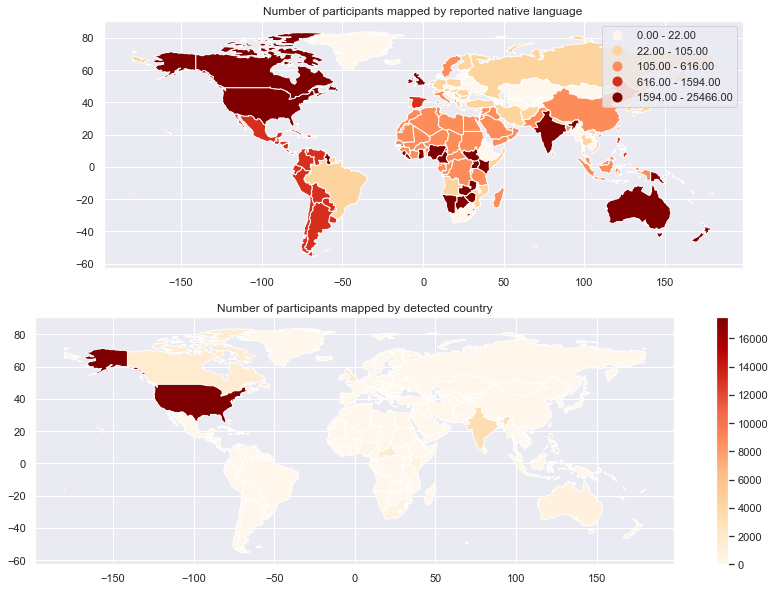

In [10]:
# World map
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
world = world[(world.pop_est>0) & (world.name!="Antarctica")]
world['iso_a2']=world['iso_a3'].apply(lambda x: x[:2])

# Dataframe for mapping country code and language
# http://download.geonames.org/export/dump/countryInfo.txt
geonames = pd.read_csv('data/geonames.txt', sep='\t', usecols=['ISO3', 'Country', 'Languages'])
geonames.dropna(inplace=True, axis=0)
geonames['lang'] = geonames['Languages'].apply(lambda x: re.split('[,-]', x)[0])

# Merge two dataframes above by country code
langmap1 = pd.merge(world, geonames[['ISO3', 'lang']], how='inner', left_on=['iso_a3'], right_on=['ISO3']).fillna(0, downcast='infer')
# Count and map participants by NATIVE_LANGUAGE
lang_native = participants.NATIVE_LANGUAGE.value_counts().to_frame()
lang_native.reset_index(inplace=True)
lang_native.rename(columns={'index':'lang', 'NATIVE_LANGUAGE': 'lang_native_cnt'}, inplace=True)
#lang_native['log_lang_native_cnt'] = lang_native.lang_native_cnt.apply(lambda x: np.log(x)) 
langmap1 = pd.merge(langmap1, lang_native, how='left', on='lang')
langmap1.fillna(0, inplace=True, downcast='infer')

# Count and map participants by DET_COUNTRY
det_country = participants.DET_COUNTRY.value_counts().to_frame()
det_country.reset_index(inplace=True)
det_country.rename(columns={'index':'iso_a2', 'DET_COUNTRY': 'det_country_cnt'}, inplace=True)
#det_country['log_det_country_cnt'] = det_country.det_country_cnt.apply(lambda x: np.log(x)) 
langmap2 = pd.merge(world, det_country, how='left', on='iso_a2')
langmap2.fillna(0, inplace=True, downcast='infer')

fig, axs = plt.subplots(nrows=2, ncols=1, figsize=(15,10))
langmap1.plot(column='lang_native_cnt', cmap='OrRd', scheme='quantiles', ax=axs[0], legend = True);
axs[0].set_title('Number of participants mapped by reported native language')
langmap2.plot(column='det_country_cnt', cmap='OrRd',  ax=axs[1], legend = True);
axs[1].set_title('Number of participants mapped by detected country')

## Encoding categories

In [11]:
from pandas.api.types import is_numeric_dtype
def categorize_age(x):
    
    if x > 0 and x < 10:
        return '0-9'
    elif x >= 10 and x < 20:
        return '10-19'
    elif x >= 20 and x < 30:
        return '20-29'
    elif x >= 30 and x < 40:
        return '30-39'
    elif x >= 40 and x < 50:
        return '40-49'
    elif x >= 50 and x < 60:
        return '50-59'
    elif x >= 60 and x < 70:
        return '60-69'
    elif x >= 70 and x < 80:
        return '70-79'
    elif x >= 80 and x < 90:
        return '80-89'
    elif x >= 90 and x < 100:
        return '90-99'
    else:
        return '100+'
    
participants['AGE_CAT'] = participants['AGE'].apply(lambda x: categorize_age(x)) 

## Sub-sampling US

In [12]:
female_US = participants[(participants.DET_COUNTRY=='US') & (participants.GENDER=='female')].sample(frac=0.318820)

In [13]:
male_US = participants[(participants.DET_COUNTRY=='US') & (participants.GENDER=='male')]

In [14]:
participants_US = pd.concat([female_US, male_US], axis=0)

In [15]:
participants.tail(5)

PARTICIPANT_ID       IP_ADDRESS  \
37601          274107   113.23.155.253   
37602          274109    216.66.93.244   
37603          274116  113.210.203.104   
37604          274128    115.178.239.7   
37605          274142      105.12.3.29   

                                                      UA  \
37601  Mozilla/5.0 (Linux; Android 8.0.0; WAS-LX2) Ap...   
37602  Mozilla/5.0 (Linux; Android 7.0; TECNO Camon C...   
37603  Mozilla/5.0 (Linux; Android 8.0.0; SM-C900F) A...   
37604  Mozilla/5.0 (Linux; Android 8.0.0; ASUS_Z012DB...   
37605  Mozilla/5.0 (Linux; Android 6.0; MYA-L22 Build...   

                 BROWSER_LANGUAGE  DEVICE  SCREEN_W  SCREEN_H  AGE  GENDER  \
37601  en-GB,en-US;q=0.9,en;q=0.8  mobile       360       640   20  female   
37602  en-GB,en-US;q=0.9,en;q=0.8  mobile       360       640   21    male   
37603              en-US,en;q=0.9  mobile       412       732   20    male   
37604  en-GB,en-US;q=0.9,en;q=0.8  mobile       360       640   25    male   
37605              en-US,en;q=0.9  mobile       360       640   24  female   

       HAS_TAKEN_TYPING_COURSE   ...   REP_F_NO  REP_F_NOTSURE        BROWSER  \
37601                        0   ...          1              0  Chrome Mobile   
37602                        0   ...          0              0  Chrome Mobile   
37603                        0   ...          1              0  Chrome Mobile   
37604                        0   ...          1              0  Chrome Mobile   
37605                        0   ...          1              0  Chrome Mobile   

            OS            D_FAMILY  D_BRAND     D_MODEL        HAND_FINGER  \
37601  Android  Generic Smartphone  Generic  Smartphone  both_hands;thumbs   
37602  Android      TECNO Camon CX    Tecno    Camon CX  both_hands;thumbs   
37603  Android  Generic Smartphone  Generic  Smartphone  both_hands;thumbs   
37604  Android         Asus Z012DB     Asus      Z012DB  both_hands;thumbs   
37605  Android             MYA-L22   Huawei     MYA-L22  both_hands;thumbs   

       DET_COUNTRY AGE_CAT  
37601           MY   20-29  
37602           US   20-29  
37603           MY   20-29  
37604           ID   20-29  
37605           ZA   20-29  

[5 rows x 43 columns]

## TOP-N aggregates

In [16]:
N = 5

# Countries
country = participants_US.DET_COUNTRY.value_counts(normalize=True).reset_index()[:N]

# Native NATIVE_LANGUAGE
native = participants_US.NATIVE_LANGUAGE.value_counts(normalize=True).reset_index()[:N]

# Genders
gender = participants_US.GENDER.value_counts(normalize=True).reset_index()[:N]

# Finnish typing
type_eng = participants_US.TYPE_TEST_LANG.value_counts(normalize=True).reset_index()[:N]

demogr_summary = pd.concat([gender, country, native, type_eng], axis=1)
demogr_summary.columns = ['GENDER', 'GENDER %', 'DET_COUNTRY', 'DET_COUNTRY %','NATIVE_LANGUAGE', 'NATIVE_LANGUAGE %', 'TYPE_TEST_LANG', 'TYPE_TEST_LANG %']
demogr_summary[['GENDER %','DET_COUNTRY %', 'NATIVE_LANGUAGE %','TYPE_TEST_LANG %']] = demogr_summary[['GENDER %','DET_COUNTRY %', 'NATIVE_LANGUAGE %','TYPE_TEST_LANG %']] * 100
demogr_summary[['GENDER %','DET_COUNTRY %', 'NATIVE_LANGUAGE %','TYPE_TEST_LANG %']] = demogr_summary[['GENDER %','DET_COUNTRY %', 'NATIVE_LANGUAGE %','TYPE_TEST_LANG %']].applymap("{:.2f}".format)
demogr_summary

GENDER GENDER % DET_COUNTRY DET_COUNTRY % NATIVE_LANGUAGE  \
0  female    50.59          US        100.00              en   
1    male    49.41         NaN           nan              es   
2     NaN      nan         NaN           nan              hi   
3     NaN      nan         NaN           nan              ar   
4     NaN      nan         NaN           nan              zh   

  NATIVE_LANGUAGE % TYPE_TEST_LANG TYPE_TEST_LANG %  
0             89.06       native          72.80  
1              4.28       always          19.58  
2              0.55      usually           5.04  
3              0.48    sometimes           1.93  
4              0.48       rarely           0.35

In [17]:
N = 5

# Hand
hand = participants_US.HAND.value_counts(normalize=True).reset_index()[:N]

# Finger
finger = participants_US.FINGER.value_counts(normalize=True).reset_index()[:N]

# Hand and finger
# participants['HAND_FINGER'] = participants['HAND']+';'+participants['FINGER'] 
hand_finger = participants_US.HAND_FINGER.value_counts(normalize=True).reset_index()[:N]

# Layout
layout = participants_US.LAYOUT.value_counts(normalize=True).reset_index()[:N]

# Keyboard app
using_app = participants_US.USING_APP.value_counts(normalize=True).reset_index()[:N]

behav_summary = pd.concat([hand, finger, hand_finger, layout, using_app], axis=1)
behav_summary.columns = ['HAND', 'HAND %', 'FINGER', 'FINGER %','HAND_FINGER', 'HAND_FINGER %', 'LAYOUT', 'LAYOUT %', 'USING_APP', 'USING_APP %']
behav_summary[['HAND %','FINGER %', 'HAND_FINGER %','LAYOUT %', 'USING_APP %']] = behav_summary[['HAND %','FINGER %', 'HAND_FINGER %','LAYOUT %', 'USING_APP %']] * 100
behav_summary[['HAND %','FINGER %', 'HAND_FINGER %','LAYOUT %', 'USING_APP %']] = behav_summary[['HAND %','FINGER %', 'HAND_FINGER %','LAYOUT %', 'USING_APP %']].applymap("{:.2f}".format)
behav_summary

HAND HAND %          FINGER FINGER %                HAND_FINGER  \
0  both_hands  85.87          thumbs    84.65          both_hands;thumbs   
1  right_hand  12.33   index_fingers     6.55          right_hand;thumbs   
2   left_hand   1.80  other-nfingers     4.83  both_hands;other-nfingers   
3         NaN    nan           other     2.42   both_hands;index_fingers   
4         NaN    nan  middle_fingers     1.55   right_hand;index_fingers   

  HAND_FINGER %  LAYOUT LAYOUT % USING_APP USING_APP %  
0         75.55  qwerty    87.21     false       84.30  
1          7.99  qwertz     6.00   notsure       11.29  
2          4.48   other     3.60    Gboard        1.81  
3          3.42  azerty     3.19  SwiftKey        0.94  
4          2.72     NaN      nan        Go        0.26

In [18]:
N = 10

# Browsers
browser = participants_US.BROWSER.value_counts(normalize=True).reset_index()[:N]

# OS 
os = participants_US.OS.value_counts(normalize=True).reset_index()[:N]

# Device family
dfam = participants_US.D_FAMILY.value_counts(normalize=True).reset_index()[:N]

# Device brand
dbrand = participants_US.D_BRAND.value_counts(normalize=True).reset_index()[:N]

# Device model
dmodel = participants_US.D_MODEL.value_counts(normalize=True).reset_index()[:N]

# Screen width
dscrw = participants_US.SCREEN_W.value_counts(normalize=True).reset_index()[:N]

# Screen height
dscrh = participants_US.SCREEN_H.value_counts(normalize=True).reset_index()[:N]

participants_US['SCREEN_DIM'] = participants_US.SCREEN_W.astype('str') + 'x' + participants_US.SCREEN_H.astype('str')
sdim = participants_US.SCREEN_DIM.value_counts(normalize=True).reset_index()[:N]

devices_summary = pd.concat([browser, os, dfam, dbrand, dmodel, dscrw, dscrh, sdim], axis=1)
devices_summary.columns = ['BROWSER', 'BROWSER %','OS', 'OS %','D_FAMILY','D_FAMILY %', 'D_BRAND', 'D_BRAND %','D_MODEL','D_MODEL %', 'SCREEN_W','SCREEN_W %', 'SCREEN_H', 'SCREEN_H %', 'SCREEN_DIM', 'SCREEN_DIM %']
devices_summary[['BROWSER %', 'OS %','D_FAMILY %', 'D_BRAND %', 'D_MODEL %', 'SCREEN_W %', 'SCREEN_H %', 'SCREEN_DIM %']] = devices_summary[['BROWSER %', 'OS %','D_FAMILY %', 'D_BRAND %', 'D_MODEL %', 'SCREEN_W %', 'SCREEN_H %', 'SCREEN_DIM %']] * 100
devices_summary[['BROWSER %', 'OS %','D_FAMILY %', 'D_BRAND %', 'D_MODEL %', 'SCREEN_W %', 'SCREEN_H %', 'SCREEN_DIM %']] = devices_summary[['BROWSER %', 'OS %','D_FAMILY %', 'D_BRAND %', 'D_MODEL %', 'SCREEN_W %', 'SCREEN_H %', 'SCREEN_DIM %']].applymap("{:.2f}".format)
devices_summary

BROWSER BROWSER %       OS   OS %            D_FAMILY  \
0               Mobile Safari     59.64      iOS  66.69              iPhone   
1               Chrome Mobile     24.81  Android  33.31  Generic Smartphone   
2            Samsung Internet      4.27      NaN    nan                iPad   
3           Chrome Mobile iOS      4.26      NaN    nan    Samsung SM-G950U   
4                    Facebook      2.00      NaN    nan    Samsung SM-G960U   
5                  UC Browser      1.80      NaN    nan    Samsung SM-G955U   
6  Mobile Safari UI/WKWebView      1.45      NaN    nan    Samsung SM-N950U   
7       Chrome Mobile WebView      0.44      NaN    nan            LG-SP200   
8                 Amazon Silk      0.38      NaN    nan             LGMP260   
9                      Chrome      0.38      NaN    nan    Samsung SM-G965U   

  D_FAMILY %          D_BRAND D_BRAND %     D_MODEL D_MODEL %  SCREEN_W  \
0      57.34            Apple     66.69      iPhone     55.75       375   
1      11.69          Generic     11.73  Smartphone     11.69       414   
2       9.21          Samsung     10.03        iPad      9.21       360   
3       1.10               LG      4.54    SM-G950U      1.10       412   
4       0.75  Generic_Android      3.24    SM-G960U      0.75      1024   
5       0.69              ZTE      0.88    SM-G955U      0.69       320   
6       0.60         Motorola      0.74    SM-N950U      0.60       768   
7       0.55           XiaoMi      0.43       SP200      0.55       424   
8       0.53           Amazon      0.38       MP260      0.53       601   
9       0.51           Google      0.24    SM-G965U      0.51       640   

  SCREEN_W %  SCREEN_H SCREEN_H % SCREEN_DIM SCREEN_DIM %  
0      30.77       667      22.06    375x667        22.06  
1      22.72       736      19.80    414x736        19.80  
2      20.65       640      16.42    360x640        16.31  
3       7.50       812       8.51    375x812         8.51  
4       6.57       768       6.60   1024x768         6.53  
5       6.07       846       4.36    412x846         4.36  
6       2.74       568       3.73    320x568         3.73  
7       0.53       740       3.09    360x740         3.09  
8       0.44      1024       2.93    414x896         2.77  
9       0.25       896       2.77   768x1024         2.70

## Descriptive statistics

In [19]:
cols_demo = ['AGE', 'HAS_TAKEN_TYPING_COURSE', 'TIME_SPENT_TYPING']
participants_US[cols_demo].describe().applymap("{:.3f}".format) #.to_csv('p_describe.csv')

AGE HAS_TAKEN_TYPING_COURSE TIME_SPENT_TYPING
count  7989.000                7989.000          7981.000
mean     24.252                   0.371             6.369
std       9.512                   0.483             6.287
min       6.000                   0.000             0.000
25%      18.000                   0.000             2.000
50%      22.000                   0.000             4.000
75%      29.000                   1.000             9.000
max      61.000                   1.000            24.000

In [20]:
cols_perf = ['WPM', 'ERROR_RATE', 'P_KPD', 'P_IKI', 'P_BSP', 'P_ECPC', 'P_KSPC']
participants[cols_perf].describe().applymap("{:.3f}".format)

WPM ERROR_RATE      P_KPD      P_IKI      P_BSP     P_ECPC  \
count  37370.000  37370.000  37370.000  37370.000  37370.000  37370.000   
mean      36.170      2.336     16.455    107.556      1.894      0.049   
std       13.221      2.079     63.546     51.599      1.963      0.051   
min        0.019      0.000     -2.761     15.140      0.000      0.000   
25%       26.749      0.971      7.748     72.238      0.200      0.005   
50%       34.477      1.739     14.259     97.043      1.467      0.037   
75%       43.978      3.061     18.346    130.999      2.867      0.074   
max      154.257     24.349  10135.432    780.660     26.867      0.761   

          P_KSPC  
count  37370.000  
mean       1.179  
std        0.184  
min        0.159  
25%        1.072  
50%        1.146  
75%        1.271  
max        3.366

In [21]:
participants.TIME_SPENT_TYPING.describe()

count    37214.000000
mean         6.508351
std          6.193183
min          0.000000
25%          2.000000
50%          4.000000
75%         10.000000
max         24.000000
Name: TIME_SPENT_TYPING, dtype: float64

In [22]:
print(participants_US.P_KSPC.describe()) 
print(participants_US.P_KSPC.skew()) 
print(participants_US.P_KSPC.kurtosis()) 
print(participants_US.P_KSPC.quantile(0.025))
print(participants_US.P_KSPC.quantile(0.975))

print(participants_US[participants_US.HAS_TAKEN_TYPING_COURSE==0].P_KSPC.mean()) 
print(participants_US[participants_US.HAS_TAKEN_TYPING_COURSE==1].P_KSPC.mean()) 

count    7989.000000
mean        1.149573
std         0.174157
min         0.183126
25%         1.059588
50%         1.122062
75%         1.223442
max         2.142867
Name: P_KSPC, dtype: float64
0.11449203918945124
4.392158932457474
0.8433112184933333
1.5373206347000001
1.148232128370563
1.1518470453581051


In [23]:
print(participants_US.WPM.describe()) 
print(participants_US.WPM.skew()) 
print(participants_US.WPM.kurtosis()) 
print(participants_US.WPM.quantile(0.025))
print(participants_US.WPM.quantile(0.975))

print(participants_US[participants_US.HAS_TAKEN_TYPING_COURSE==0].WPM.mean()) 
print(participants_US[participants_US.HAS_TAKEN_TYPING_COURSE==1].WPM.mean()) 

count    7989.000000
mean       39.036548
std        14.069030
min         0.019106
25%        29.099633
50%        37.503000
75%        47.600436
max       148.166012
Name: WPM, dtype: float64
0.7342750516214149
1.732271118588777
15.770285120064724
69.96477915858364
39.00758261808642
39.0856807714384


In [24]:
print(participants_US.ERROR_RATE.describe()) 
print(participants_US.ERROR_RATE.skew()) 
print(participants_US.ERROR_RATE.kurtosis()) 
print(participants_US.ERROR_RATE.quantile(0.025))
print(participants_US.ERROR_RATE.quantile(0.975))

print(participants_US[participants_US.HAS_TAKEN_TYPING_COURSE==0].ERROR_RATE.mean()) 
print(participants_US[participants_US.HAS_TAKEN_TYPING_COURSE==1].ERROR_RATE.mean()) 

count    7989.000000
mean        2.346743
std         2.028057
min         0.000000
25%         1.018676
50%         1.769166
75%         3.056769
max        23.789693
Name: ERROR_RATE, dtype: float64
2.4434123103806833
10.979050041640958
0.1697792869269949
7.638885115862109
2.454980404618057
2.163145201502262


In [25]:
print(participants_US[(participants_US.HAND=="left_hand") & (participants_US.FINGER=="index_fingers")].WPM.describe()) 
print(participants_US[(participants_US.HAND=="left_hand") & (participants_US.FINGER=="index_fingers")].WPM.quantile(0.025))
print(participants_US[(participants_US.HAND=="left_hand") & (participants_US.FINGER=="index_fingers")].WPM.quantile(0.975))

count    33.000000
mean     25.167730
std       8.912431
min       9.020862
25%      17.810106
50%      26.123023
75%      27.822078
max      52.935253
Name: WPM, dtype: float64
12.10232832180348
44.288628547569594


# Performance

C:\Users\matti\Anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "
C:\Users\matti\Anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


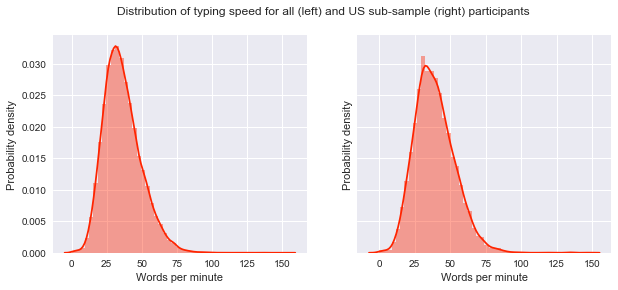

In [36]:
# Performance : WPM
ROWS = 1
COLS = 2

fig, axs = plt.subplots(nrows=ROWS, ncols=COLS, figsize=(10,4), sharey=True)
plt.suptitle('Distribution of typing speed for all (left) and US sub-sample (right) participants')

sns.distplot(participants.WPM, ax=axs[0])
axs[0].set(ylabel="Probability density")
axs[0].set(xlabel='Words per minute')

sns.distplot(participants_US.WPM, ax=axs[1])
axs[1].set(ylabel="Probability density")
axs[1].set(xlabel='Words per minute')

plt.savefig('comp_wpm.png', bbox_inches='tight')

In [35]:
# Performance : ERROR RATE
ROWS = 1
COLS = 2

fig, axs = plt.subplots(nrows=ROWS, ncols=COLS, figsize=(10,4), sharey=True)
plt.suptitle('Distribution of error rate for all (left) and US sub-sample (right) participants')

sns.distplot(participants.ERROR_RATE, ax=axs[0])
axs[0].set(ylabel="Probability density")
axs[0].set(xlabel='Uncorrected error rate (%)')

sns.distplot(participants_US.ERROR_RATE, ax=axs[1])
axs[1].set(ylabel="Probability density")
axs[1].set(xlabel='Uncorrected error rate (%)')

plt.savefig('comp_er.png', bbox_inches='tight')

C:\Users\matti\Anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "
C:\Users\matti\Anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


In [34]:
# Performance : KSPC
ROWS = 1
COLS = 2

fig, axs = plt.subplots(nrows=ROWS, ncols=COLS, figsize=(10,4), sharey=True)
plt.suptitle('Distribution of keystrokes per character for all (left) and US sub-sample (right) participants')

sns.distplot(participants.P_KSPC, ax=axs[0])
axs[0].set(ylabel="Probability density")
axs[0].set(xlabel='Keystrokes per character')

sns.distplot(participants_US.P_KSPC, ax=axs[1])
axs[1].set(ylabel="Probability density")
axs[1].set(xlabel='Keystrokes per character')

plt.savefig('comp_kspc.png', bbox_inches='tight')

C:\Users\matti\Anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "
C:\Users\matti\Anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


In [129]:
# Performance 
ROWS = 1
COLS = 2

paper_metrics = ['WPM', 'ERROR_RATE']
fig, axs = plt.subplots(nrows=ROWS, ncols=COLS, figsize=(10,4))
plt.suptitle('Performance metrics by participant')
for i in range(0,len(paper_metrics)): 
    f = paper_metrics[i]
    rown = 0
    coln = i
    sns.distplot(participants[f], ax=axs[i])
    axs[i].set(ylabel="Probability density")
axs[0].set(xlabel='Words per minute')
axs[1].set(xlabel='Uncorrected error rate (%)')

plt.savefig('performance_measures.png', bbox_inches='tight')

C:\Users\matti\Anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "
C:\Users\matti\Anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


C:\Users\matti\Anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "
C:\Users\matti\Anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


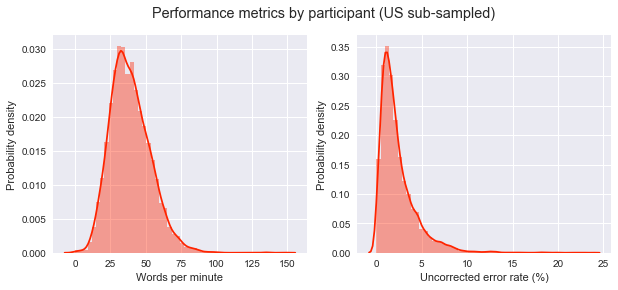

In [131]:
# Performance 
ROWS = 1
COLS = 2

paper_metrics = ['WPM', 'ERROR_RATE']
fig, axs = plt.subplots(nrows=ROWS, ncols=COLS, figsize=(10,4))
plt.suptitle('Performance metrics by participant (US sub-sampled)')
for i in range(0,len(paper_metrics)): 
    f = paper_metrics[i]
    rown = 0
    coln = i
    sns.distplot(participants_US[f], ax=axs[i])
    axs[i].set(ylabel="Probability density")
axs[0].set(xlabel='Words per minute')
axs[1].set(xlabel='Uncorrected error rate (%)')

plt.savefig('performance_measures_US.png', bbox_inches='tight')

# Factors versus performance

In [34]:
import statsmodels.api as sm
import statsmodels.formula.api as smf


In [26]:
participants.columns

Index(['PARTICIPANT_ID', 'IP_ADDRESS', 'UA', 'BROWSER_LANGUAGE', 'DEVICE',
       'SCREEN_W', 'SCREEN_H', 'AGE', 'GENDER', 'HAS_TAKEN_TYPING_COURSE',
       'LAYOUT', 'WPM', 'ERROR_RATE', 'NATIVE_LANGUAGE', 'KEYBOARD_TYPE',
       'USING_APP', 'USING_FEATURES', 'FINGERS', 'TIME_SPENT_TYPING',
       'TYPE_TEST_LANG', 'P_KPD', 'P_IKI', 'P_BSP', 'P_ECPC', 'P_UILEN',
       'P_KSPC', 'HAND', 'FINGER', 'NUM_FINGERS', 'REP_F_SWIPE',
       'REP_F_PREDICTION', 'REP_F_AUTOCORRECTION', 'REP_F_OTHER', 'REP_F_NO',
       'REP_F_NOTSURE', 'BROWSER', 'OS', 'D_FAMILY', 'D_BRAND', 'D_MODEL',
       'HAND_FINGER', 'DET_COUNTRY', 'AGE_CAT'],
      dtype='object')

In [27]:
factors = ['GENDER', 'HAS_TAKEN_TYPING_COURSE', 'NATIVE_LANGUAGE', 'LAYOUT', 'HAND_FINGER', 'AGE_CAT']

                            OLS Regression Results                            
Dep. Variable:                    WPM   R-squared:                       0.003
Model:                            OLS   Adj. R-squared:                  0.003
Method:                 Least Squares   F-statistic:                     50.27
Date:                Mon, 21 Jan 2019   Prob (F-statistic):           1.57e-22
Time:                        11:20:07   Log-Likelihood:            -1.4946e+05
No. Observations:               37370   AIC:                         2.989e+05
Df Residuals:                   37367   BIC:                         2.989e+05
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept            36.0030      0.08

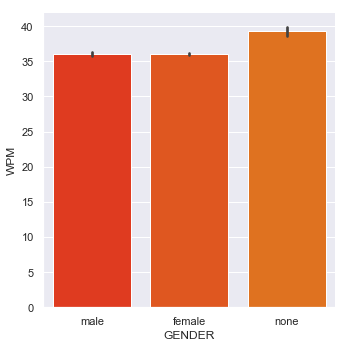

In [37]:
sns.catplot(x="GENDER", y="WPM", kind='bar', data=participants);
results = smf.ols('WPM ~ C(GENDER)', data=participants).fit() #Specify C for Categorical
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                    WPM   R-squared:                       0.001
Model:                            OLS   Adj. R-squared:                  0.001
Method:                 Least Squares   F-statistic:                     23.11
Date:                Mon, 21 Jan 2019   Prob (F-statistic):           1.54e-06
Time:                        11:20:32   Log-Likelihood:            -1.4950e+05
No. Observations:               37370   AIC:                         2.990e+05
Df Residuals:                   37368   BIC:                         2.990e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                                      coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------------
Intercept 

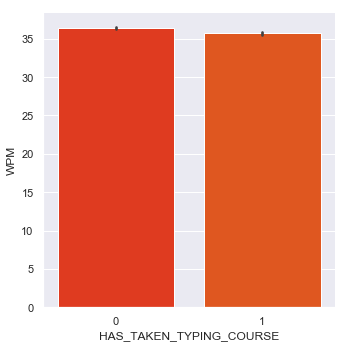

In [38]:
sns.catplot(x="HAS_TAKEN_TYPING_COURSE", y="WPM", kind='bar', data=participants);
results = smf.ols('WPM ~ C(HAS_TAKEN_TYPING_COURSE)', data=participants).fit() #Specify C for Categorical
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                    WPM   R-squared:                       0.034
Model:                            OLS   Adj. R-squared:                  0.033
Method:                 Least Squares   F-statistic:                     124.5
Date:                Mon, 21 Jan 2019   Prob (F-statistic):          1.84e-231
Time:                        12:03:13   Log-Likelihood:            -1.2817e+05
No. Observations:               32084   AIC:                         2.564e+05
Df Residuals:                   32074   BIC:                         2.565e+05
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
Intercept               

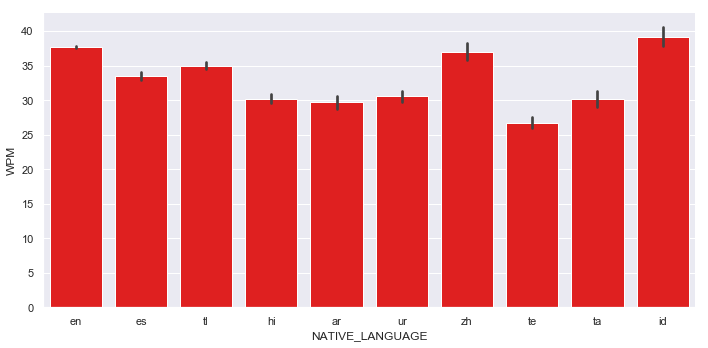

In [93]:
top10_languages = ['en', 'es', 'tl', 'hi', 'ar', 'ur', 'zh', 'te', 'ta', 'id']
sns.catplot(x="NATIVE_LANGUAGE", y="WPM", kind='bar', data=participants[participants.NATIVE_LANGUAGE.isin(top10_languages)], aspect=2, color='red', order=top10_languages);
results = smf.ols('WPM ~ C(NATIVE_LANGUAGE)', data=participants[participants.NATIVE_LANGUAGE.isin(top10_languages)]).fit() #Specify C for Categorical
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                    WPM   R-squared:                       0.024
Model:                            OLS   Adj. R-squared:                  0.024
Method:                 Least Squares   F-statistic:                     302.6
Date:                Mon, 21 Jan 2019   Prob (F-statistic):          3.91e-194
Time:                        11:22:02   Log-Likelihood:            -1.4906e+05
No. Observations:               37370   AIC:                         2.981e+05
Df Residuals:                   37366   BIC:                         2.982e+05
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
Intercept              29.8809    

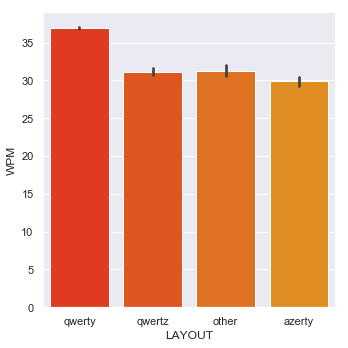

In [40]:
sns.catplot(x="LAYOUT", y="WPM", kind='bar', data=participants);
results = smf.ols('WPM ~ C(LAYOUT)', data=participants).fit() #Specify C for Categorical
print(results.summary())

array(['both_hands;thumbs', 'right_hand;thumbs',
       'both_hands;other-nfingers', 'both_hands;index_fingers',
       'right_hand;index_fingers', 'both_hands;other', 'left_hand;thumbs',
       'right_hand;middle_fingers', 'both_hands;middle_fingers',
       'right_hand;other', 'right_hand;other-nfingers',
       'left_hand;index_fingers', 'left_hand;middle_fingers',
       'left_hand;other-nfingers', 'left_hand;other'], dtype=object)

                            OLS Regression Results                            
Dep. Variable:                    WPM   R-squared:                       0.068
Model:                            OLS   Adj. R-squared:                  0.068
Method:                 Least Squares   F-statistic:                     194.6
Date:                Mon, 21 Jan 2019   Prob (F-statistic):               0.00
Time:                        12:07:18   Log-Likelihood:            -1.4819e+05
No. Observations:               37370   AIC:                         2.964e+05
Df Residuals:                   37355   BIC:                         2.965e+05
Df Model:                          14                                         
Covariance Type:            nonrobust                                         
                                                  coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------

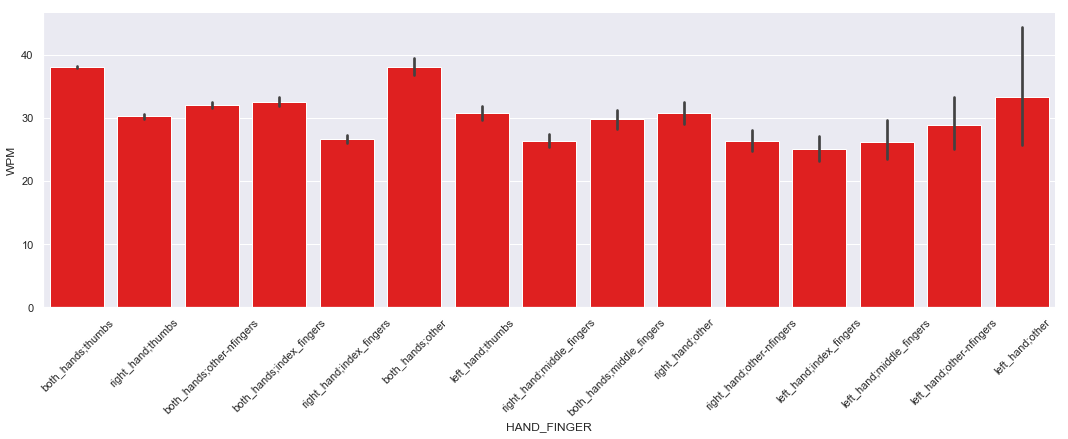

In [109]:
postures = participants.HAND_FINGER.value_counts().reset_index()['index'].values
g = sns.catplot(x="HAND_FINGER", y="WPM", kind='bar', data=participants, aspect=3, color='red', order=postures);
g.set_xticklabels(rotation=45)
results = smf.ols('WPM ~ C(HAND_FINGER)', data=participants).fit() #Specify C for Categorical
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                    WPM   R-squared:                       0.069
Model:                            OLS   Adj. R-squared:                  0.069
Method:                 Least Squares   F-statistic:                     462.4
Date:                Mon, 21 Jan 2019   Prob (F-statistic):               0.00
Time:                        11:46:56   Log-Likelihood:            -1.4817e+05
No. Observations:               37370   AIC:                         2.964e+05
Df Residuals:                   37363   BIC:                         2.964e+05
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
Intercept              24.3476    

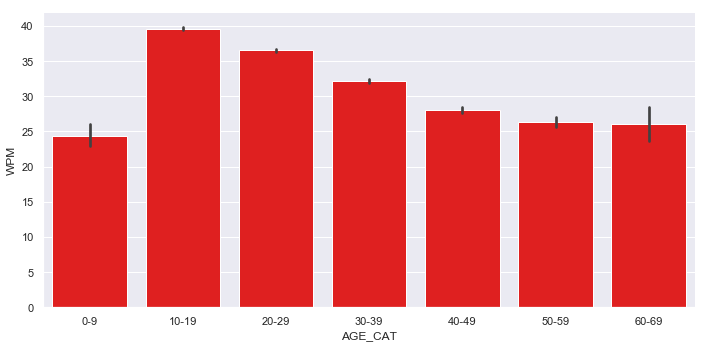

In [69]:
order=['0-9', '10-19', '20-29', '30-39', '40-49', '50-59', '60-69']
sns.catplot(x="AGE_CAT", y="WPM", kind='bar', data=participants, aspect=2, color='red', order=order);
results = smf.ols('WPM ~ C(AGE_CAT)', data=participants).fit() #Specify C for Categorical
print(results.summary())

In [112]:
participants.NUM_FINGERS.value_counts()

2.0     30203
1.0      5256
10.0      314
4.0       230
3.0       134
8.0       115
6.0        79
5.0        56
7.0         9
9.0         4
Name: NUM_FINGERS, dtype: int64

                            OLS Regression Results                            
Dep. Variable:                    WPM   R-squared:                       0.052
Model:                            OLS   Adj. R-squared:                  0.052
Method:                 Least Squares   F-statistic:                     222.3
Date:                Tue, 22 Jan 2019   Prob (F-statistic):               0.00
Time:                        09:03:38   Log-Likelihood:            -1.4461e+05
No. Observations:               36400   AIC:                         2.892e+05
Df Residuals:                   36390   BIC:                         2.893e+05
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
Intercept                 29

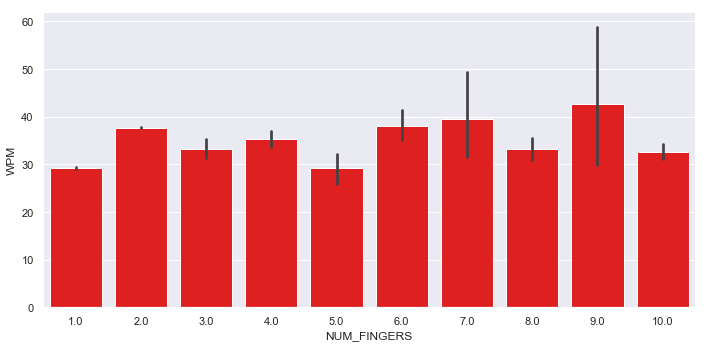

In [151]:
#order=['0-9', '10-19', '20-29', '30-39', '40-49', '50-59', '60-69']
sns.catplot(x="NUM_FINGERS", y="WPM", kind='bar', data=participants, aspect=2, color='red');
results = smf.ols('WPM ~ C(NUM_FINGERS)', data=participants).fit() #Specify C for Categorical
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                    WPM   R-squared:                       0.035
Model:                            OLS   Adj. R-squared:                  0.035
Method:                 Least Squares   F-statistic:                     271.0
Date:                Tue, 22 Jan 2019   Prob (F-statistic):          1.26e-285
Time:                        09:49:24   Log-Likelihood:            -1.4884e+05
No. Observations:               37370   AIC:                         2.977e+05
Df Residuals:                   37364   BIC:                         2.977e+05
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                                   coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------
Intercept       

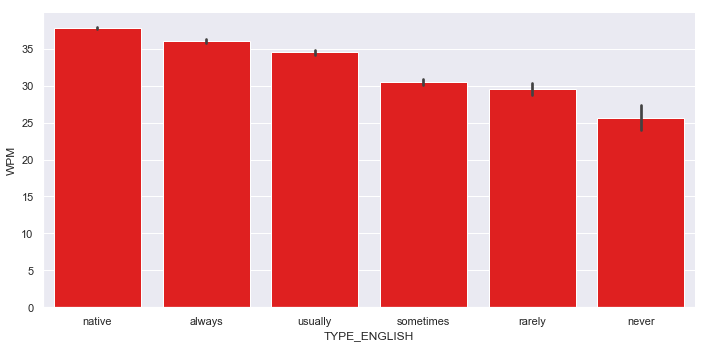

In [174]:
order=['native', 'always', 'usually', 'sometimes', 'rarely', 'never']
sns.catplot(x="TYPE_TEST_LANG", y="WPM", kind='bar', data=participants, aspect=2, color='red', order=order);
results = smf.ols('WPM ~ C(TYPE_TEST_LANG)', data=participants).fit() #Specify C for Categorical
print(results.summary())

C:\Users\matti\Anaconda3\lib\site-packages\seaborn\regression.py:546: UserWarning: The `size` paramter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)
C:\Users\matti\Anaconda3\lib\site-packages\seaborn\regression.py:546: UserWarning: The `size` paramter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


Text(8.96,0.5,'(Uncorrected) error rate (ER)')

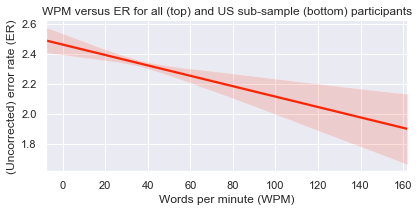

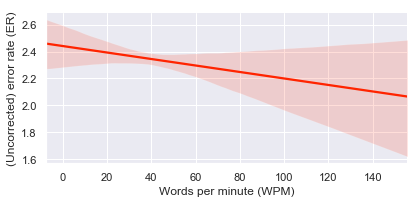

In [60]:
sns.lmplot(x='WPM', y='ERROR_RATE', data=participants, scatter=False, size=3, aspect=2) 
ax = plt.gca()
ax.set_title("WPM versus ER for all (top) and US sub-sample (bottom) participants")
ax.set_xlabel("Words per minute (WPM)")
ax.set_ylabel("(Uncorrected) error rate (ER)")

sns.lmplot(x='WPM', y='ERROR_RATE', data=participants_US, scatter=False, size=3, aspect=2) 
ax = plt.gca()
ax.set_xlabel("Words per minute (WPM)")
ax.set_ylabel("(Uncorrected) error rate (ER)")

C:\Users\matti\Anaconda3\lib\site-packages\seaborn\regression.py:546: UserWarning: The `size` paramter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)
C:\Users\matti\Anaconda3\lib\site-packages\seaborn\regression.py:546: UserWarning: The `size` paramter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


Text(2.96,0.5,'Keystrokes per character (KSPC)')

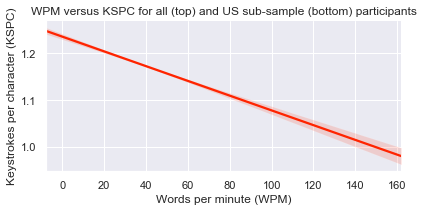

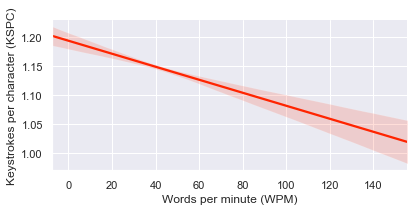

In [61]:
sns.lmplot(x='WPM', y='P_KSPC', data=participants, scatter=False, size=3, aspect=2) 
ax = plt.gca()
ax.set_title("WPM versus KSPC for all (top) and US sub-sample (bottom) participants")
ax.set_xlabel("Words per minute (WPM)")
ax.set_ylabel("Keystrokes per character (KSPC)")

sns.lmplot(x='WPM', y='P_KSPC', data=participants_US, scatter=False, size=3, aspect=2) 
ax = plt.gca()
ax.set_xlabel("Words per minute (WPM)")
ax.set_ylabel("Keystrokes per character (KSPC)")

## Typist groups

In [110]:
print(participants.WPM.quantile(0.1))
print(participants.WPM.quantile(0.9))

20.807606185610137
54.03724697734248


In [165]:
pd.unique(participants.TYPE_TEST_LANG)

array(['sometimes', 'usually', 'always', 'native', 'rarely', 'never'],
      dtype=object)

In [113]:
all_fast = participants[participants.WPM > participants.WPM.quantile(0.9)]
all_slow = participants[participants.WPM < participants.WPM.quantile(0.1)]

us_fast = participants_US[participants_US.WPM > participants_US.WPM.quantile(0.9)]
us_slow = participants_US[participants_US.WPM < participants_US.WPM.quantile(0.1)]

In [176]:
print("All, fast")
print(all_fast[all_fast.TYPE_TEST_LANG=='always'].WPM.describe())
print("All, slow")
print(all_slow[all_slow.TYPE_TEST_LANG=='always'].WPM.describe())
print("US, fast")
print(us_fast[us_fast.TYPE_TEST_LANG=='always'].WPM.describe())
print("US, slow")
print(us_slow[us_slow.TYPE_TEST_LANG=='always'].WPM.describe())

All, fast
count    743.000000
mean      62.826923
std        7.763733
min       54.046471
25%       56.926768
50%       60.728955
75%       66.441878
max       97.418941
Name: WPM, dtype: float64
All, slow
count    814.000000
mean      16.552497
std        3.716077
min        0.216070
25%       14.908283
50%       17.556421
75%       19.314085
max       20.806776
Name: WPM, dtype: float64
US, fast
count    166.000000
mean      66.126451
std        8.562095
min       57.501820
25%       59.701197
50%       63.392496
75%       69.925253
max       97.418941
Name: WPM, dtype: float64
US, slow
count    166.000000
mean      17.710114
std        4.066056
min        0.216070
25%       15.468465
50%       18.620052
75%       20.790541
max       22.431738
Name: WPM, dtype: float64


###### 

In [183]:
results = smf.ols('WPM ~ C(GENDER) + C(HAS_TAKEN_TYPING_COURSE) + C(TYPE_TEST_LANG) + C(NATIVE_LANGUAGE) + C(HAND_FINGER) + C(LAYOUT) + C(AGE_CAT) + C(NUM_FINGERS)', data=participants_US).fit() #Specify C for Categorical
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                    WPM   R-squared:                       0.207
Model:                            OLS   Adj. R-squared:                  0.194
Method:                 Least Squares   F-statistic:                     16.02
Date:                Tue, 22 Jan 2019   Prob (F-statistic):          4.41e-300
Time:                        09:59:38   Log-Likelihood:                -31532.
No. Observations:                7989   AIC:                         6.332e+04
Df Residuals:                    7860   BIC:                         6.422e+04
Df Model:                         128                                         
Covariance Type:            nonrobust                                         
                                                     coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------

In [149]:
pd.unique(all_fast.HAND_FINGER)

array(['both_hands;thumbs', 'right_hand;thumbs', 'both_hands;other',
       'both_hands;index_fingers', 'both_hands;other-nfingers',
       'right_hand;index_fingers', 'left_hand;thumbs',
       'both_hands;middle_fingers', 'right_hand;other', 'left_hand;other',
       'right_hand;other-nfingers', 'left_hand;middle_fingers',
       'left_hand;index_fingers', 'left_hand;other-nfingers',
       'right_hand;middle_fingers'], dtype=object)

## Visualisations

In [28]:
#cols = ['SCREEN_W', 'SCREEN_H', 'AGE', 'GENDER', 'WPM', 'ERROR_RATE', 'TIME_SPENT_TYPING']
#sns.pairplot(participants[cols], hue="GENDER",  plot_kws={'alpha': 0.2})

In [29]:
# Prepare data for visualisations
typing_features = pd.DataFrame({'REP_FEATURE': ['swipe', 'prediction', 'autocorr.', 'other', 'no', 'not sure'], 
                                'count': [participants.REP_F_SWIPE.value_counts()[1], 
                                          participants.REP_F_PREDICTION.value_counts()[1], 
                                          participants.REP_F_AUTOCORRECTION.value_counts()[1],
                                          participants.REP_F_OTHER.value_counts()[1],
                                          participants.REP_F_NO.value_counts()[1],
                                          participants.REP_F_NOTSURE.value_counts()[1]]})
typing_features.sort_values(by='count', inplace=True, ascending=False)
typing_features['freq'] = typing_features['count']*100 / sum(typing_features['count'])

using_app = participants.USING_APP.value_counts().reset_index()
using_app.rename(columns={'index':'REP_USING_APP', 'USING_APP':'count'}, inplace=True)
using_app['freq'] = using_app['count']*100 / sum(using_app['count'])

# Count number of fingers
fingers = participants.NUM_FINGERS.value_counts().reset_index()
fingers['number'] = pd.to_numeric(fingers['index'], errors='coerce')
fingers.rename(columns={'NUM_FINGERS':'count', 'number': 'REP_NUM_FINGERS'}, inplace=True)
fingers = fingers[['REP_NUM_FINGERS', 'count']]
fingers.dropna(inplace=True)
fingers.sort_values(by='REP_NUM_FINGERS', inplace=True)
fingers.REP_NUM_FINGERS = fingers.REP_NUM_FINGERS.astype(int)
fingers['freq'] = fingers['count']*100 / sum(fingers['count'])


Text(700.949,0.5,'Frequency [%]')

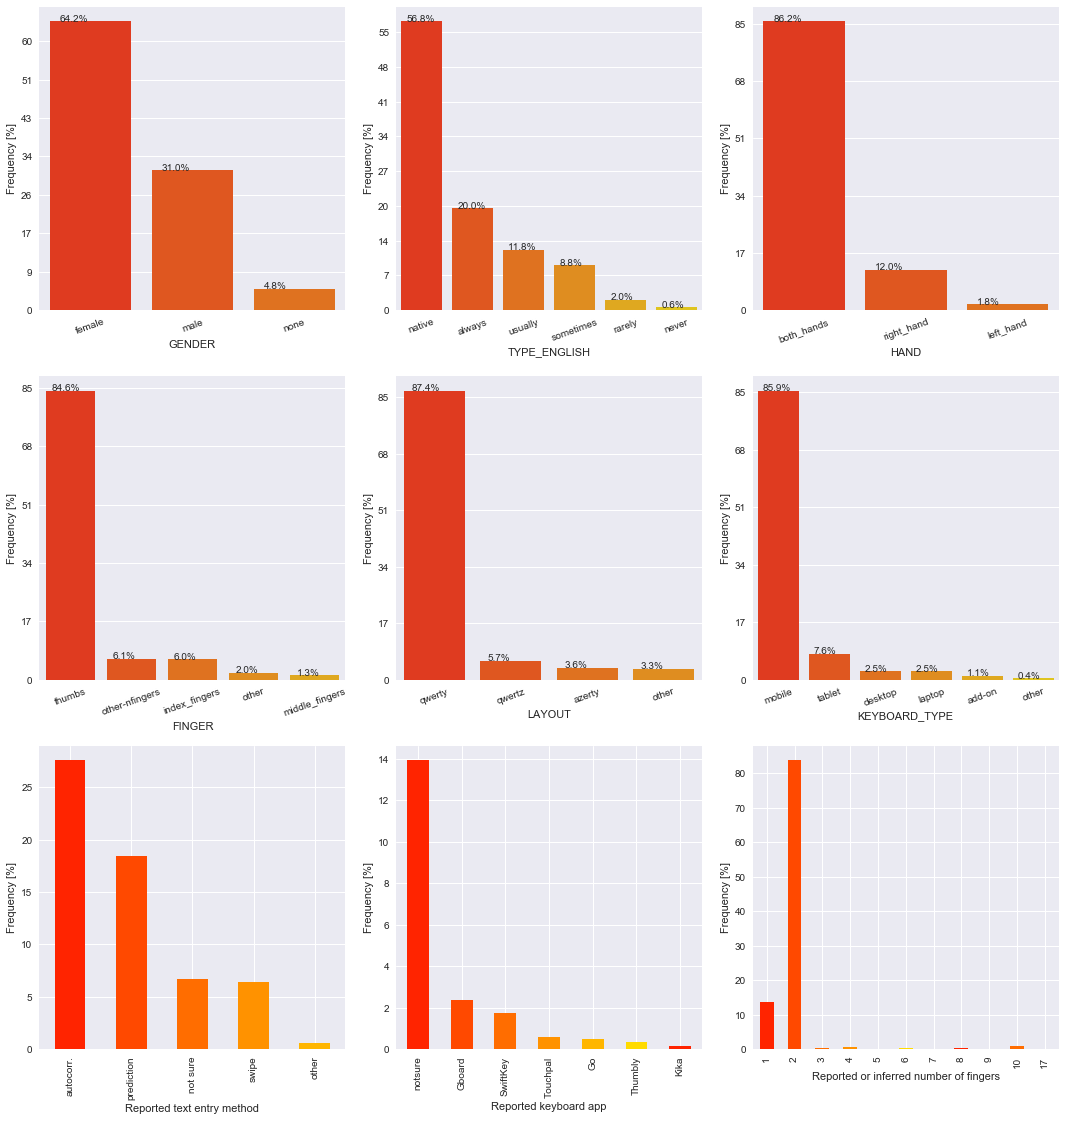

In [30]:
from pandas.api.types import is_string_dtype
from pandas.api.types import is_numeric_dtype

#with plt.xkcd():
total = len(participants)*1.
ROWS = 3
COLS = 3
fig, axs = plt.subplots(nrows=ROWS, ncols=COLS, figsize=(15,15))

features = ['GENDER','TYPE_TEST_LANG','HAND',
            'FINGER','LAYOUT','KEYBOARD_TYPE']
for i in range(0,len(features)):
    f = features[i]
    rown = int(i/COLS)
    coln = i%COLS
    if is_numeric_dtype(participants[f]):
        sns.distplot(participants[f], ax=axs[rown,coln])
        axs[rown,coln].set(ylabel="Density")

    if is_string_dtype(participants[f]):
        #sns.barplot(x=participants[f], y=participants[f], data=participants, estimator=lambda x: len(x) / len(df) * 100)
        sns.countplot(participants[f], order = participants[f].value_counts().index, ax=axs[rown,coln])
        #adjust the ticklabel to the desired format, without changing the position of the ticks. 
        axs[rown,coln].set_yticklabels(map('{:.0f}'.format, 100*axs[rown,coln].yaxis.get_majorticklocs()/total))
        axs[rown,coln].set_xticklabels(axs[rown,coln].get_xticklabels(),rotation=20)
        for p in axs[rown,coln].patches:
            axs[rown,coln].annotate('{:.1f}%'.format(100*p.get_height()/total), (p.get_x()+0.1, p.get_height()+5))
        axs[rown,coln].set(ylabel="Frequency [%]")


plt.tight_layout()

last_row_idx = 2
typing_features[typing_features.REP_FEATURE != 'no'].plot("REP_FEATURE", "freq", kind="bar", ax=axs[last_row_idx,0], legend=False)
axs[last_row_idx,0].set_xlabel('Reported text entry method')
axs[last_row_idx,0].set_ylabel('Frequency [%]')

using_app[(using_app.freq > 0.1) & (using_app.REP_USING_APP != 'false')].plot("REP_USING_APP", "freq", kind='bar',  ax=axs[last_row_idx,1], legend=False)
axs[last_row_idx,1].set_xlabel('Reported keyboard app')
axs[last_row_idx,1].set_ylabel('Frequency [%]')

fingers.plot("REP_NUM_FINGERS", "freq", kind="bar", ax=axs[last_row_idx,2], legend=False)
axs[last_row_idx,2].set_xlabel('Reported or inferred number of fingers')
axs[last_row_idx,2].set_ylabel('Frequency [%]')
 

## Distributions

In [ ]:
sns.set_palette('RdYlGn')
metrics = ['WPM', 'ERROR_RATE', 'P_KPD', 'P_IKI', 'P_BSP', 'P_ECPC', 'P_UILEN', 'P_KSPC']
latents = ['AGE_CAT', 'GENDER', 'HAND', 'FINGER', 'LAYOUT', 'HAS_TAKEN_TYPING_COURSE']

p_data = participants[['WPM', 'ERROR_RATE', 'P_KPD', 'P_IKI', 'P_BSP', 'P_ECPC', 'P_UILEN', 'P_KSPC', 'AGE_CAT', 'GENDER', 'HAND', 'FINGER', 'LAYOUT', 'HAS_TAKEN_TYPING_COURSE']]
ROWS = len(metrics)
COLS = len(latents)
fig, axs = plt.subplots(nrows=ROWS, ncols=COLS, figsize=(20,30))
plt.suptitle('Performance of participants on different metrocs by group')
#for i in range(0,len(metrics)): 
#    for j in range(0,len(latents)): 
#        f = metrics[i]
#        lat = latents[j]
#        rown = i
#        coln = j
#        if is_numeric_dtype(participants[f]):
#            sns.distplot(participants[f], ax=axs[rown,coln])
#            axs[rown,coln].set(ylabel="Density")
        
for i in range(0,len(latents)): 
    f = latents[i]
    g = sns.pairplot(data = p_data, hue=f, plot_kws={'alpha': 0.4})
    g = g.set(xlim=(-5, 120), ylim=(-5, 25))

## Bivariate

In [39]:
participants.columns

Index(['PARTICIPANT_ID', 'IP_ADDRESS', 'UA', 'BROWSER_LANGUAGE', 'DEVICE',
       'SCREEN_W', 'SCREEN_H', 'AGE', 'GENDER', 'HAS_TAKEN_TYPING_COURSE',
       'LAYOUT', 'WPM', 'ERROR_RATE', 'NATIVE_LANGUAGE', 'KEYBOARD_TYPE',
       'USING_APP', 'USING_FEATURES', 'FINGERS', 'TIME_SPENT_TYPING',
       'TYPE_TEST_LANG', 'P_KPD', 'P_IKI', 'P_BSP', 'P_ECPC', 'P_UILEN',
       'P_KSPC', 'HAND', 'FINGER', 'NUM_FINGERS', 'REP_F_SWIPE',
       'REP_F_PREDICTION', 'REP_F_AUTOCORRECTION', 'REP_F_OTHER', 'REP_F_NO',
       'REP_F_NOTSURE', 'BROWSER', 'OS', 'D_FAMILY', 'D_BRAND', 'D_MODEL',
       'HAND_FINGER', 'DET_COUNTRY', 'AGE_CAT'],
      dtype='object')

#### WPM vs ERROR_RATE

In [ ]:
sns.set_palette('RdYlGn')
latents = ['AGE_CAT', 'GENDER', 'HAND', 'FINGER', 'LAYOUT', 'HAS_TAKEN_TYPING_COURSE']

for i in range(0,len(latents)): 
    f = latents[i]
    g = sns.lmplot(x="WPM", y="ERROR_RATE", data = participants, hue=f, scatter_kws={'alpha': 0.4})
    g = g.set(xlim=(-5, 120), ylim=(-5, 25))

        
        


#### WPM vs KSPC

In [ ]:
sns.set_palette('RdYlGn')
latents = ['AGE_CAT', 'GENDER', 'HAND', 'FINGER', 'LAYOUT', 'HAS_TAKEN_TYPING_COURSE']

for i in range(0,len(latents)): 
    f = latents[i]
    g = sns.lmplot(x="WPM", y="P_KSPC", data = participants, hue=f, scatter_kws={'alpha': 0.4})
    g = g.set(xlim=(-5, 120), ylim=(-1, 3))

#### WPM vs ESPC

In [ ]:
sns.set_palette('RdYlGn')
latents = ['AGE_CAT', 'GENDER', 'HAND', 'FINGER', 'LAYOUT', 'HAS_TAKEN_TYPING_COURSE']

for i in range(0,len(latents)): 
    f = latents[i]
    g = sns.lmplot(x="WPM", y="P_ECPC", data = participants, hue=f, scatter_kws={'alpha': 0.4})
    g = g.set(xlim=(-5, 120), ylim=(-0.1, 0.5))

#### WPM vs P_KPD

In [ ]:
sns.set_palette('RdYlGn')
latents = ['AGE_CAT', 'GENDER', 'HAND', 'FINGER', 'LAYOUT', 'HAS_TAKEN_TYPING_COURSE']

for i in range(0,len(latents)): 
    f = latents[i]
    g = sns.lmplot(x="WPM", y="P_KPD", data = participants, hue=f, scatter_kws={'alpha': 0.4})
    g = g.set(xlim=(-5, 120), ylim=(-1, 200))

#### WPM vs P_IKI

In [ ]:
sns.set_palette('RdYlGn')
latents = ['AGE_CAT', 'GENDER', 'HAND', 'FINGER', 'LAYOUT', 'HAS_TAKEN_TYPING_COURSE']

for i in range(0,len(latents)): 
    f = latents[i]
    g = sns.lmplot(x="WPM", y="P_IKI", data = participants, hue=f, scatter_kws={'alpha': 0.4})
    g = g.set(xlim=(-5, 120), ylim=(-1, 600))

#### WPM vs ERROR_RATE

In [16]:
#ROWS = 1
#COLS = 1
#fig, axs = plt.subplots(nrows=ROWS, ncols=COLS, figsize=(5,5), sharey=True)
#subset = (participants.WPM > 20) &  (participants.WPM < 80) & (participants.ERROR_RATE >= 0) &  (participants.ERROR_RATE < 4) 
#sns.jointplot(x='WPM', y='ERROR_RATE', data=participants[subset], kind="kde")

#sns.lmplot(x="total_bill", y="tip", hue="smoker", data=tips)
#sns.lmplot(x='WPM', y='ERROR_RATE', data=participants, scatter=False);


In [17]:
#sns.jointplot(x='AGE', y='WPM', data=participants, kind="kde")
#sns.lmplot(x='AGE', y='WPM', data=participants, scatter=False);

In [18]:

#sns.jointplot(x='AGE', y='ERROR_RATE', data=participants, kind="kde")
#sns.lmplot(x='AGE', y='ERROR_RATE', data=participants, scatter=False);

#### WPM vs typing startegy

In [ ]:
P1 no
P2 no
P3 auto
P4 no
P5 swype
P6 auto
P7 predict
P8 predict
P9 predict
P10 swype
P11 predict
P12 swype
P13 swype
P14 predict/auto
P15 predict




In [119]:
participants['HAND_FINGER'] = participants['HAND']+';'+participants['FINGER'] 

In [120]:
participants.HAND_FINGER.value_counts()

both_hands;thumbs            6203
right_hand;thumbs             785
both_hands;other-nfingers     551
both_hands;index_fingers      267
right_hand;index_fingers      196
both_hands;other              100
left_hand;thumbs               89
right_hand;middle_fingers      60
both_hands;middle_fingers      58
right_hand;other               38
right_hand;other-nfingers      34
left_hand;index_fingers        14
left_hand;middle_fingers        7
left_hand;other-nfingers        6
left_hand;other                 5
Name: HAND_FINGER, dtype: int64

In [28]:
#sns.catplot(x="FINGERS", y="WPM", hue="GENDER", col="HAND", aspect=.6, kind="swarm", data=participants);

In [29]:
sns.set_palette('RdYlGn')

In [ ]:
fig, axs = plt.subplots(nrows=1, ncols=1, figsize=(15,10))
sns.boxplot(x="ERROR_RATE", y="WPM", hue="GENDER", data=participants, ax=axs);
axs.set_xticklabels(axs[0].get_xticklabels(),rotation=80)


[Text(0,0,'thumbs'),
 Text(0,0,'index_fingers'),
 Text(0,0,'other'),
 Text(0,0,'other-nfingers'),
 Text(0,0,'middle_fingers')]

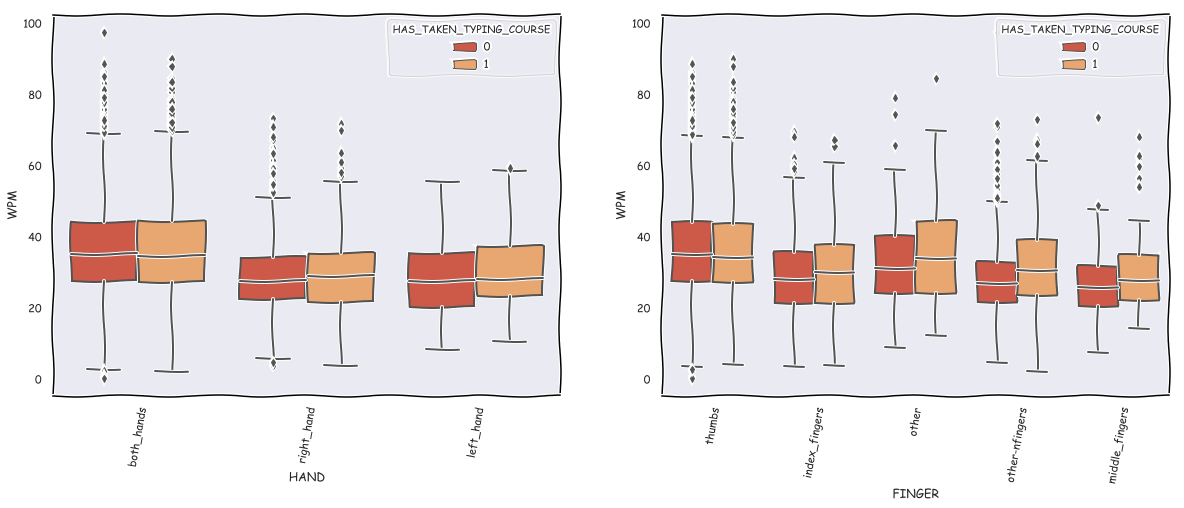

In [100]:
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(20,7))
sns.boxplot(x="HAND", y="WPM", hue="HAS_TAKEN_TYPING_COURSE", data=participants, ax=axs[0]);
axs[0].set_xticklabels(axs[0].get_xticklabels(),rotation=80)

sns.boxplot(x="FINGER", y="WPM", hue="HAS_TAKEN_TYPING_COURSE", data=participants, ax=axs[1]);
axs[1].set_xticklabels(axs[1].get_xticklabels(),rotation=80)

[Text(0,0,'thumbs'),
 Text(0,0,'index_fingers'),
 Text(0,0,'other'),
 Text(0,0,'other-nfingers'),
 Text(0,0,'middle_fingers')]

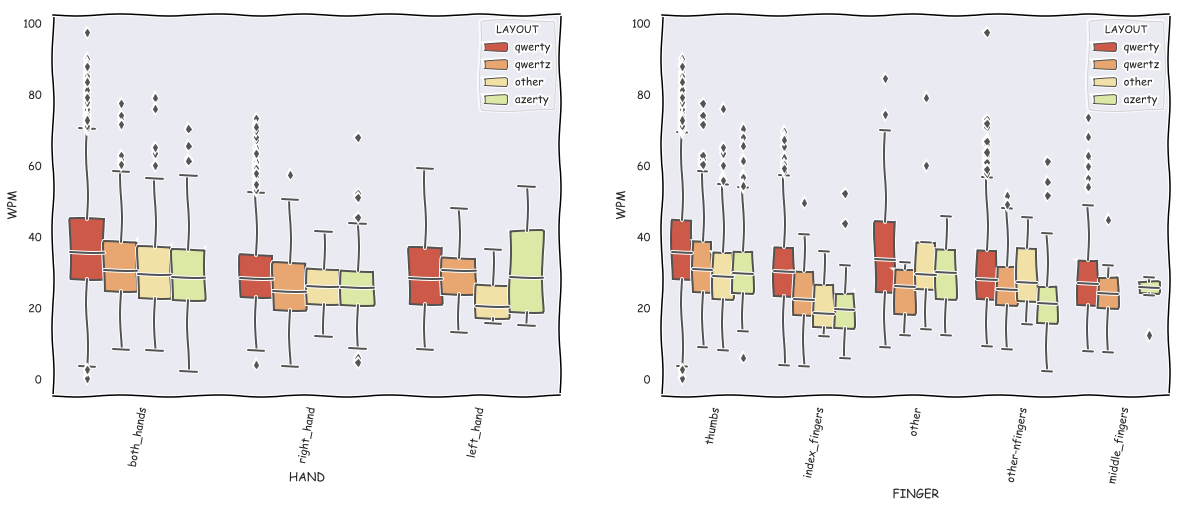

In [101]:
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(20,7))
sns.boxplot(x="HAND", y="WPM", hue="LAYOUT", data=participants, ax=axs[0]);
axs[0].set_xticklabels(axs[0].get_xticklabels(),rotation=80)

sns.boxplot(x="FINGER", y="WPM", hue="LAYOUT", data=participants, ax=axs[1]);
axs[1].set_xticklabels(axs[1].get_xticklabels(),rotation=80)

[Text(0,0,'thumbs'),
 Text(0,0,'index_fingers'),
 Text(0,0,'other'),
 Text(0,0,'other-nfingers'),
 Text(0,0,'middle_fingers')]

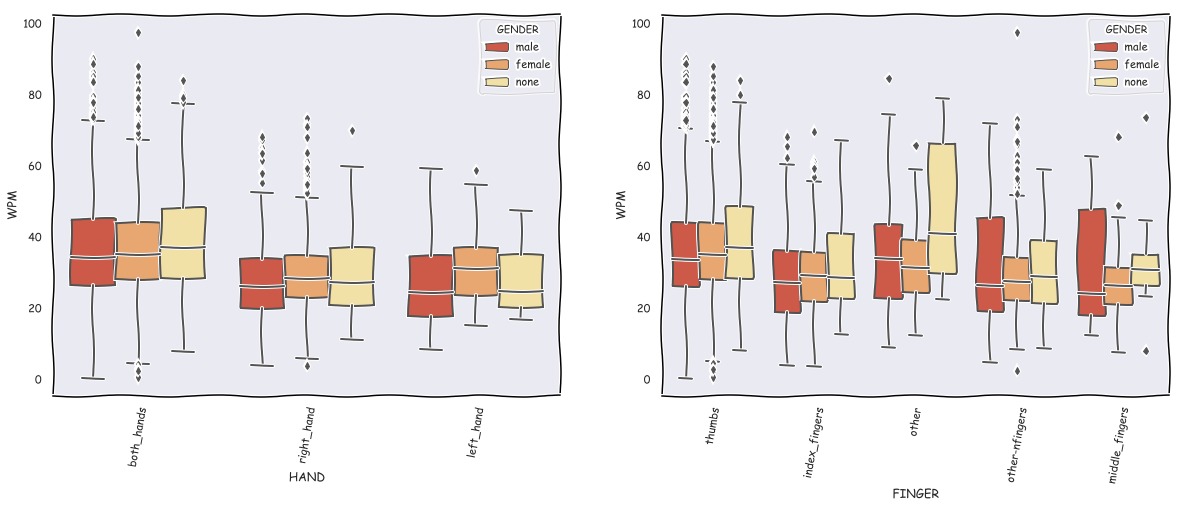

In [102]:
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(20,7))
sns.boxplot(x="HAND", y="WPM", hue="GENDER", data=participants, ax=axs[0]);
axs[0].set_xticklabels(axs[0].get_xticklabels(),rotation=80)

sns.boxplot(x="FINGER", y="WPM", hue="GENDER",  data=participants, ax=axs[1]);
axs[1].set_xticklabels(axs[1].get_xticklabels(),rotation=80)

[Text(0,0,'Facebook'),
 Text(0,0,'Chrome Mobile WebView'),
 Text(0,0,'Chrome'),
 Text(0,0,'Chrome Mobile'),
 Text(0,0,'Mobile Safari'),
 Text(0,0,'Samsung Internet'),
 Text(0,0,'Mobile Safari UI/WKWebView'),
 Text(0,0,'Chrome Mobile iOS'),
 Text(0,0,'Crosswalk'),
 Text(0,0,'UC Browser'),
 Text(0,0,'Amazon Silk'),
 Text(0,0,'Firefox Mobile'),
 Text(0,0,'Pinterest'),
 Text(0,0,'Opera Mobile'),
 Text(0,0,'Edge Mobile'),
 Text(0,0,'Android'),
 Text(0,0,'Firefox iOS')]

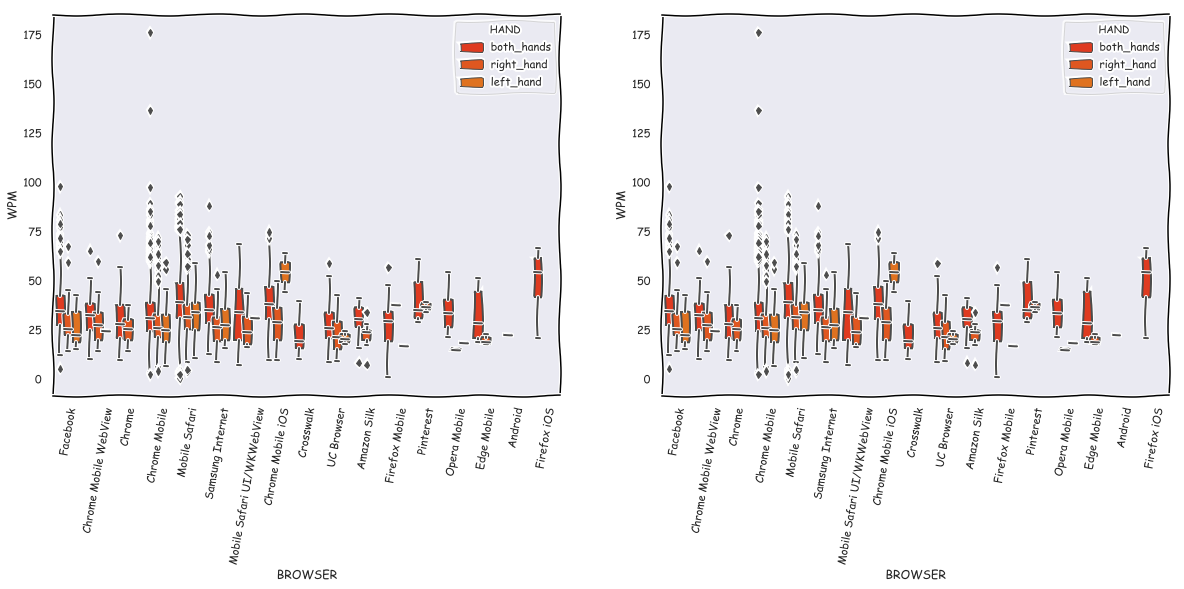

In [63]:
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(20,7))
sns.boxplot(x="BROWSER", y="WPM", hue="HAND", data=participants, ax=axs[0]);
axs[0].set_xticklabels(axs[0].get_xticklabels(),rotation=80)

sns.boxplot(x="BROWSER", y="WPM", hue="HAND",  data=participants, ax=axs[1]);
axs[1].set_xticklabels(axs[1].get_xticklabels(),rotation=80)